In [1]:
from environment import GridWorld
from HystereticQLearner import HystereticQLearner
from agent import RandomAgent, QLearner

In [2]:
import random
random.seed()

In [3]:
experiments = (
{
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda _: 0.1,
    "exploration_rate": lambda _: 0.25
},{
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda t: 1/t,
    "exploration_rate": lambda t: 1/t
},
    {
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda _: 0.1,
    "exploration_rate": lambda t: 1/t
},
{
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda t: 1/t,
    "exploration_rate": lambda _: 0.1
})

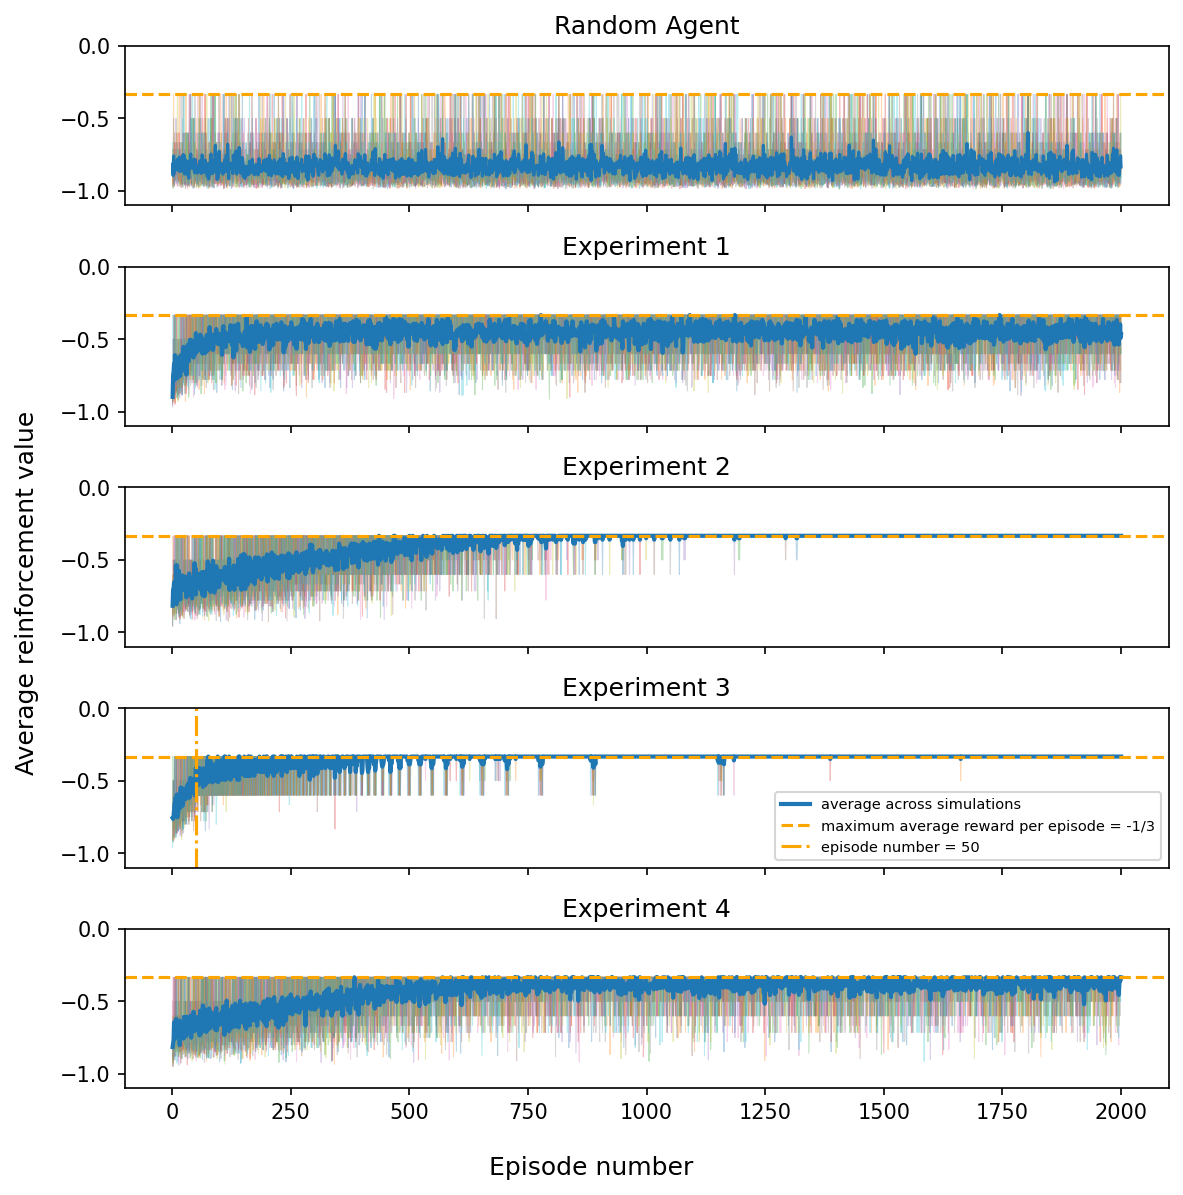

In [6]:
def simulate_grid_world(agent, task, t):
    state = task.get_state()
    while not task.isTerminalState(state):
        t += 1
        
        action = agent.action_selection(state, None, t)
        reward, new_state = task.respond_to_action(action)
        if(isinstance(agent, HystereticQLearner)):
            agent.update(state, action, new_state, reward, t)
        else:
            agent.update(new_state, reward, t)
        state = new_state
    return t

import numpy as np

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(8, 8), sharex=True)
fig.set_dpi(150)

num_episodes = 2000 # 150 was good
num_simulations = 10

decrease_rate = lambda _: 0.01
for j, exp in enumerate(experiments):
    i = j + 1
    rewards = np.zeros((num_simulations, num_episodes))

    discount_rate = exp["discount_rate"]
    learning_rate = exp["learning_rate"]
    exploration_rate = exp["exploration_rate"]

    for sim in range(num_simulations):
        t = 0
        task = GridWorld(4, start_state = (3,0), terminal_states=[(0,0), (3,3)])
#         agent = QLearner(task, exploration_rate, learning_rate, discount_rate)
        agent = HystereticQLearner(task, exploration_rate, learning_rate, discount_rate, decrease_rate)

        prev_t = t
        for ep in range(num_episodes):
            t = simulate_grid_world(agent, task, t)
            num_steps = t - prev_t
            rewards[sim][ep] = agent.accumulated_reward / num_steps
            agent.accumulated_reward = 0
            task.reset_state()
            prev_t = t
        axs[i].plot(range(1, num_episodes + 1), rewards[sim], alpha=0.3, lw=0.5) # if sim < 1 else do_nothing()
    
    average = np.average(rewards, axis = 0)
    axs[i].plot(range(1, num_episodes + 1), average, lw=2, label="average across simulations")

    
    median = np.median(rewards, axis = 0)
    #axs[i].plot(range(1, num_episodes + 1), median, label="median", lw=2)
    
    axs[i].set_title("Experiment {}".format(i))

    # max reward
    #axs[i].axhline(-1, label="Maximum reward = -1", ls = '--')

        
rewards = np.zeros((num_simulations, num_episodes))
# random agent
for sim in range(num_simulations):
    t = 0
    task = GridWorld(4, start_state = (3,0), terminal_states=[(0,0), (3,3)])
    agent = RandomAgent(task)
    state = task.get_state()
    prev_t = t
    for ep in range(num_episodes):
        t = simulate_grid_world(agent, task, t)
        num_steps = t - prev_t
        rewards[sim][ep] = agent.accumulated_reward / num_steps
        agent.accumulated_reward = 0
        task.reset_state()
        prev_t = t
    axs[0].plot(range(1, num_episodes + 1), rewards[sim], alpha=0.3, lw=0.5)

average = np.average(rewards, axis = 0)
axs[0].plot(range(1, num_episodes + 1), average)

median = np.median(rewards, axis = 0)
#axs[0].plot(range(1, num_episodes + 1), median, label="median", lw=2)

axs[0].set_title("Random Agent")


# max reward
for i, ax in enumerate(axs):
    ax.axhline(-1/3, label="maximum average reward per episode = -1/3", ls = '--', c='orange')

    if(i == 3):
        ep_number = 50
        axs[i].axvline(ep_number, ls='-.', c='orange', label="episode number = {}".format(ep_number))

        axs[i].legend(loc='best', fontsize=7)
    
    ax.set_ylim(-1.1, 0)

        
fig.supxlabel('Episode number')
fig.supylabel('Average reinforcement value')

plt.tight_layout()